# Classification Example

## 0. Import Packages

In addition to the usual imports, we will be using [Keras](https://keras.io/about/) to build our model. Keras is a deep learning Python package that allows us to easily build many different types of neural networks. In this example, we will be using a standard [feedforward neural network](https://en.wikipedia.org/wiki/Feedforward_neural_network) configured for binary classification. The equivalent scikit-learn model is `sklearn.neural_network.MLPClassifier`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/usr/local/anaconda3/lib/python3.7/site-packages/pydot.py:18: UserWarning: Couldn't import dot_parser, loading of dot files will not be possible.
  "Couldn't import dot_parser, "


## 1. Preprocess Data

Neural networks are prone to overfitting, so it's best to reserve them for large, non-linear data sets. We will be using simulated data for the [Major Atmospheric Gamma Imaging Cherenkov Telescopes (MAGIC)](https://en.wikipedia.org/wiki/MAGIC_(telescope)). The goal is to identify primary gamma rays, labeled 'g', from the high energy background hadrons, labeled 'h'. You can learn more about the features of this data set [here](https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope).

First, let's import the data and relabel the classes 'g' and 'h' as 1 and 0. Neural networks can only function with numerical data. 

In [2]:
data = pd.read_csv('magic_telescope.csv', header=0)
data = data.replace({'g':1, 'h':0})
data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,Class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,0
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,0
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,0
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,0


Split the training and testing data as usual.

In [3]:
y = data['Class']
X = data.drop(columns=['Class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Training set size = ", len(X_train))
print("Testing set size = ", len(X_test))

Training set size =  15216
Testing set size =  3804


Do you notice any issues in the data? Hint: compare the values in columns 'fConc' and 'fDist'. How would the relative differences in magnitude affect the training of the neural network?

To prevent features with large values from dominating the contributions to the error, we will use `sklearn.preprocessing.StandardScaler` to scale each column by the standard deviation and shift the mean to zero. Not only does this help the network treat the features on equal footing, it also decreases the risk of floating point errors. This is because the density of floating point numbers is highest for small numbers.

In [4]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
X_train_scaled

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.752397,-0.830057,-1.232820,1.861539,1.758468,0.452790,0.048989,-0.310942,0.646258,-0.299423
1,-0.231318,0.655021,1.041491,-0.965791,-0.920454,0.096690,0.372263,-1.389397,-0.841962,-1.113952
2,1.213354,1.166406,0.020636,-0.731861,-0.727297,0.146344,0.354286,1.516076,-0.896012,1.763692
3,-0.795705,-0.707759,-1.040893,1.550724,1.943501,0.402201,0.082509,-0.217734,0.329379,-0.154023
4,-0.950744,-0.583851,-1.393818,1.943878,1.418187,0.322927,-0.269628,0.555420,-0.709063,-0.142611
...,...,...,...,...,...,...,...,...,...,...
15211,1.144910,0.944438,2.376716,-1.278787,-1.244488,-2.595139,1.176752,1.056861,-0.905435,1.791230
15212,1.658586,2.828479,2.054296,-1.542163,-1.579353,-2.104348,0.764686,1.062893,0.667495,0.903840
15213,0.806985,0.204394,1.271972,-1.008323,-0.901499,-0.596177,1.012343,0.904701,-0.965315,1.307816
15214,-0.706886,-0.434296,-0.459393,0.701162,0.570644,-0.235287,-0.410228,0.477429,0.444626,-0.757536


## 2. Build Neural Network

Here is a plot of some common activation functions:

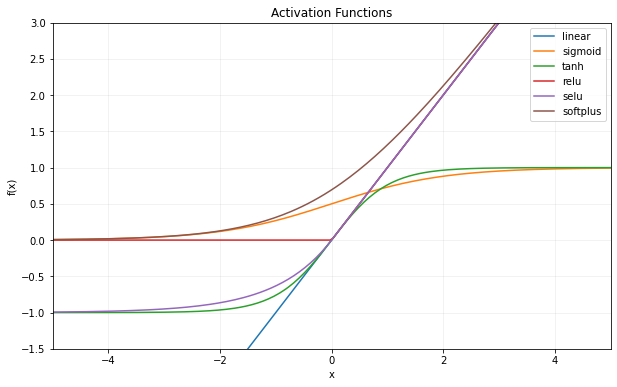

In [5]:
%run FNN-Mathematics.ipynb

We can build a feedforward neural network by stacking `keras.layers.Dense` objects of the appropriate sizes and activation functions. Here are some tips for configuring the network for binary classification:

1. The most popular activation function for the hidden layers is the Rectified Linear Unit (ReLU). If you need a smoother function, Softplus, SELU, and ELU are good options. By the way, bounded functions like sigmoid and hyperbolic tangent are not off limits for the hidden layers! They just might not give the best performance. 

2. Since the target labels are either 0 or 1, the output of the network should be restricted to the range (0,1). The sigmoid function is the most common choice for the output layer activation function.

3. Loss functions like MSE are not great for binary classification (great for regression though). Instead, we want to use binary cross-entropy, also known as log loss. [This](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) is a great explanation of how it works. 

4. Neural networks can take a long time to train, so start with a small number of hidden neurons, hidden layers, and training epochs.

5. [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is the most popular choice of optimizer. It works quickly and reliably for most applications.

6. For huge data sets, it takes a long time to calculate the loss over the full training set for each epoch. Instead, calculate the loss over a small sample batch of data and update the parameters more frequently. Just make sure to choose the batch size and the number of epochs so that the network "sees" the whole data set at least once.

7. Use the optional parameter `validation_split` to set aside some of the training data to estimate the testing accuracy. Tracking the training accuracy alongside the validation accuracy will help determine if we're overtraining. The goal is too have two curves that level out to similar values.

Now let's set a baseline for the performance we expect from an FNN. The simplest possible network is a shallow FNN with only one hidden node:

In [55]:
# seed here for reproducible results, you can remove this
np.random.seed(1)

# build Keras Sequential model
model = Sequential()
model.add(Dense(1, input_dim=10, activation='relu', name='hidden'))
model.add(Dense(1, activation="sigmoid", name='output'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 1)                 11        
_________________________________________________________________
output (Dense)               (None, 1)                 2         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


Train the network on both the scaled and unscaled data sets.

In [56]:
epochs = 100
verbose = 0

training = model.fit(X_train, y_train, epochs=epochs, verbose=verbose)
training_scaled = model.fit(X_train_scaled, y_train, epochs=epochs, verbose=verbose)

The output of the `fit` function is a Keras object that has a dictionary called `history`. The dictionary keys depend on the parameters of the model.

In [57]:
print(type(training))
print(type(training.history))
print(training.history.keys())

<class 'keras.callbacks.callbacks.History'>
<class 'dict'>
dict_keys(['loss', 'accuracy'])


Plot the training history to see how scaling the data set affected the accuracy. If you use the `validation_split` parameter, you can also plot the validation accuracies.

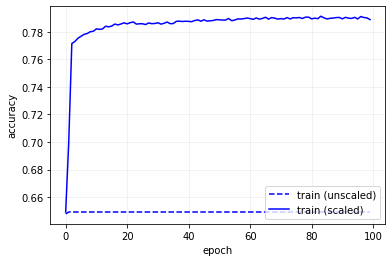

In [58]:
plt.plot(training.history['accuracy'], color='b', linestyle='--', label='train (unscaled)')
plt.plot(training_scaled.history['accuracy'], color='b', label='train (scaled)')
#plt.plot(training.history['val_accuracy'], color='r', linestyle='--', label='validation (unscaled)')
#plt.plot(training_scaled.history['val_accuracy'], color='r', label='validation (scaled)')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.grid(alpha=0.2)
plt.show()

Score the model over the scaled testing data:

In [61]:
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Loss = ", loss)
print("Test Accuracy = ", accuracy)

Test Loss =  0.4574795555867858
Test Accuracy =  0.793638288974762


Sometimes, the accuracy is not enough to evaluate the performance of the model. In our case, it's worse for the model to classify the signal (gamma rays) as background noise (hadrons) than the other way around. So we need a confusion matrix.

In [60]:
# get prediction
y_pred = model.predict(X_test_scaled)

# change float outputs to integers
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)

# confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("True Positives = ", tp)
print("True Negatives = ", tn)
print("False Positives = ", fp)
print("False Negatives = ", fn)

True Positives =  2217
True Negatives =  802
False Positives =  548
False Negatives =  237


## 3. Tune Hyperparameters

You've seen what a shallow FNN can do with only one hidden node. Are you surprised by the performance? How many parameters were tuned?

Now it's time to experiment. Here are some changes you could make to the above code to improve the accuracy:

1. Increase the number of hidden nodes.

    * Do you notice a plateau in accuracy as you add more and more hidden nodes?
    
    
2. Increase the number of layers.

    * How many parameters are in a shallow network with $N$ nodes? If $N$ is even, how many parameters are in a two-hidden-layer network with $N/2$ nodes each?
    
    * Why does increasing the depth (usually) improve the performance of the network?
    
    
3. Split the training data into training-validation sets using the `validation_split` parameter for the `fit` function. 

    * If you plot the validation accuracy with the training accuracy, do the curves level out to similar values? If they don't level out at all, you might need to increase the number of epochs. 
    
    * If you set `shuffle=True` to resplit the data after each epoch, the accuracy curves should become noisier. Why is noise sometimes a good thing when using gradient descent methods?
    
    
4. Change the `batch_size` to something much smaller than your training set, like 100. 

    * Do you notice a change in the training time?
    
    
5. Change the hidden layer activation function. [Here](https://keras.io/api/layers/activations/#available-activations) are your options.

    * Which activation function gave the best accuracy?